# Calculate air-sea fluxes
This builds on `step_1_combine_filter_inputs.ipynb`

> Note: The last time I ran this it would only run on `pangeo/pangeo-notebook:ebeb9dd` not on the latest image.

In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
# !mamba install aerobulk-python -y

In [3]:
import json
import gcsfs
import xarray as xr

import matplotlib.pyplot as plt
import numpy as np
import os
import dask

from aerobulk import noskin
from scale_aware_air_sea.utils import maybe_write_to_temp_and_reload,open_zarr, weighted_coarsen
from scale_aware_air_sea.parameters import get_params

import cartopy.crs as ccrs

In [4]:
# Reproducibility info
os.environ['JUPYTER_IMAGE']

'pangeo/pangeo-notebook:ebeb9dd'

In [5]:
# # local debugging version
# from distributed import Client
# client = Client()
# client

## Failure with newer image versions!
I have experienced some gnarly dependency issues when running this on newer pangeo image version (for example: `2023.05.18`). There is an error that states that dependencies between client and workers are not the same. 
Likely issue is something change in dask? Hard to test this without a custom image (with pinned dask versions). 

TODO: Once the manuscript is submitted I should invest some time to figure out exactly what is going on. 
[Manual image options for the hub](https://github.com/jupyterhub/kubespawner/pull/735) will help a lot here, so I should wait for that.

In [6]:
# import subprocess
# import logging
# from distributed import WorkerPlugin

# class MambaPlugin(WorkerPlugin):
#     """
#     Install packages on a worker as it starts up.

#     Parameters
#     ----------
#     packages : List[str]
#         A list of packages to install with pip on startup.
#     """
#     def __init__(self, packages):
#         self.packages = packages

#     def setup(self, worker):
#         logger = logging.getLogger("distributed.worker")
#         subprocess.call(['mamba', 'install'] + self.packages)
#         logger.info("Installed %s", self.packages)

# from dask_gateway import Gateway
# gateway = Gateway()

# # close existing clusters
# open_clusters = gateway.list_clusters()
# print(list(open_clusters))
# if len(open_clusters)>0:
#     for c in open_clusters:
#         cluster = gateway.connect(c.name)
#         cluster.shutdown()  

# options = gateway.cluster_options()
# # really unsure how to get the most out of our n2 node allowance here
# # Should I go for 'full' utilization of each node with large workers?

# # options.worker_memory = 115 # Have been able to get 115 so far.
# # options.worker_cores = 15 # somehow I can not get all 16 cores here....  Need to understand these limits and how to split up a node properly.
# options.worker_memory = 57 # Have been able to get 115 so far.
# options.worker_cores = 7 # somehow I can not get all 16 cores here....  Need to understand these limits and how to split up a node properly.


# # Create a cluster with those options
# cluster = gateway.new_cluster(options)
# client = cluster.get_client()

# plugin = MambaPlugin(['aerobulk-python'])
# client.register_worker_plugin(plugin)
# cluster.adapt(1,100)
# client

# ### debugging attempt
# # from distributed import CondaInstall
# # plugin = CondaInstall(packages=["scikit-learn"], conda_options=["--update-deps"])

# # from distributed import LocalCluster, Client
# # cluster = LocalCluster(n_workers=4, threads_per_worker=2)
# # client = Client(cluster)
# # client

In [7]:
# def check_version():
#     import aerobulk, dask, distributed
#     return aerobulk.__version__,dask.__version__, distributed.__version__

# client.run(check_version)

## Trying this with coiled
Since I was moronic enough to delete all the flux output 😭, I have to reprocess them. 
While we are at that, lets see if coiled can handle the dependency issue (see above) better. I guess the proper way to redo this without coiled is to make a project specific docker image (that might be useful anyways).


In [8]:
# !pip install coiled

In [9]:
import coiled
cluster = coiled.Cluster(n_workers=10, worker_vm_types= 'n2d-highmem-8', spot_policy='spot_with_fallback')
client = cluster.get_client()
client

Output()

xmip 0.7.1 has requirement xgcm<0.7.0, but you have xgcm 0.8.1.

Package - xmip, Pip check had the following issues that need resolving: 
xmip 0.7.1 has requirement xgcm<0.7.0, but you have xgcm 0.8.1.

╭────────────────────────────────────────── Package Info ──────────────────────────────────────────╮
│                           ╷                                                                      │
│   Package                 │ Note                                                                 │
│ ╶─────────────────────────┼────────────────────────────────────────────────────────────────────╴ │
│   scale-aware-air-sea     │ Wheel built from /home/jovyan/PROJECTS/scale-aware-air-sea           │
│                           ╵                                                                      │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── Not Synced with Cluster ─────────────────────────────────────╮
│            ╷                                                                         ╷           │
│   Package  │ Error                                                                   │ Risk      │
│ ╶──────────┼─────────────────────────────────────────────────────────────────────────┼─────────╴ │
│   xmip     │ Pip check had the following issues that need resolving:                 │ Warning   │
│            │ xmip 0.7.1 has requirement xgcm<0.7.0, but you have xgcm 0.8.1.         │           │
│            ╵                                                                         ╵           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

Connection method: Cluster object,Cluster type: coiled.Cluster
Dashboard: https://cluster-rwxms.dask.host/wn0n6OmI5lUxV4Ow/status,
Dashboard: https://cluster-rwxms.dask.host/wn0n6OmI5lUxV4Ow/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tls://10.1.0.38:8786,Workers: 0
Dashboard: /user/jbusecke/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
def compute_fluxes(
    ds,
    algo,
    method,
    sst_name = 'surface_temp',
    t_name = 't_ref',
    q_name = 'q_ref',
    u_name = 'u_relative',
    v_name = 'v_relative',
    slp_name = 'slp',
    skin_correction = False
):
    ds = ds.copy() # TODO: Does this help with inplace modification? If so, why?
    # input dependent on method
    # FIXME: Technically we should probably make the 'filtered' suffix optional, since this could also be coarseened?
    if method == 'smooth_tracer':
        sst = ds[sst_name+'_filtered']
        t = ds[t_name+'_filtered']
        q = ds[q_name+'_filtered']
        u = ds[u_name]
        v = ds[v_name]
        slp = ds[slp_name+'_filtered']
    elif method == 'smooth_vel':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_filtered']
        v = ds[v_name+'_filtered']
        slp = ds[slp_name]
    elif method == 'smooth_vel_tracer_atmos':
        sst = ds[sst_name]
        t = ds[t_name+'_filtered']
        q = ds[q_name+'_filtered']
        u = ds[u_name+'_filtered_atmos_only']
        v = ds[v_name+'_filtered_atmos_only']
        slp = ds[slp_name+'_filtered']
    elif method == 'smooth_vel_tracer_ocean':
        sst = ds[sst_name+'_filtered']
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_filtered_ocean_only']
        v = ds[v_name+'_filtered_ocean_only']
        slp = ds[slp_name]
    elif method == 'smooth_vel_ocean':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name+'_filtered_ocean_only']
        v = ds[v_name+'_filtered_ocean_only']
        slp = ds[slp_name]
    elif method == 'smooth_all':
        sst = ds[sst_name+'_filtered']
        t = ds[t_name+'_filtered']
        q = ds[q_name+'_filtered']
        u = ds[u_name+'_filtered']
        v = ds[v_name+'_filtered']
        slp = ds[slp_name+'_filtered']
    elif method == 'smooth_none':
        sst = ds[sst_name]
        t = ds[t_name]
        q = ds[q_name]
        u = ds[u_name]
        v = ds[v_name]
        slp = ds[slp_name]
    else:
        raise ValueError(f'`method`{method} not recognized')
        
    # if skin_correction:
    #     func = noskin
    
    ## test ranges on first timestep
    noskin(
        sst.isel(time=0),
        t.isel(time=0),
        q.isel(time=0),
        u.isel(time=0),
        v.isel(time=0),
        slp=slp.isel(time=0),
        algo=algo,
        zt=2,
        zu=10,
        input_range_check=True
    )
    
    
    ds_out = xr.Dataset()
    (
        ds_out['ql'],
        ds_out['qh'],
        ds_out['taux'],
        ds_out['tauy'],
        ds_out['evap']
    ) =  noskin(
        sst,
        t,
        q,
        u,
        v,
        slp=slp,
        algo=algo,
        zt=2,
        zu=10,
        input_range_check=False
    )
    return ds_out


def _concat_flux_methods(ds, algo, smoothing_methods, skin_correction):
    algo_datasets = []
    for method in smoothing_methods:
        ds_method = compute_fluxes(ds, algo, method, skin_correction=skin_correction)
        ds_method = ds_method.assign_coords(smoothing=method)
        algo_datasets.append(ds_method)

    ds_algo = xr.concat(algo_datasets, dim='smoothing')
    ds_algo = ds_algo.assign_coords({'algo':f"{algo}{'_'+skin if skin_correction else ''}"})
    return ds_algo
    

def flux_compute_wrapper_filter(ds:xr.Dataset, algo_options:list[str, bool], smoothing_methods: list[str], ice_mask:xr.DataArray) -> xr.Dataset:
    """Wrapper to apply the flux computation for different algorithms and smoothed fields
    
    """
    datasets = []
    for algo, skin_correction in algo_options:
        ds_algo = _concat_flux_methods(ds, algo, smoothing_methods, skin_correction)
        datasets.append(ds_algo)
    ds_out = xr.concat(datasets, dim='algo')
    
    # mask with ice_mask
    # Ice mask needs to be applied after, because tempo-spatially variable nans lead to problems with the flux calculation
    ds_out = ds_out.where(ice_mask)
    return ds_out

In [10]:
algo_options_prod = [
    ('ecmwf', False), 
]

algo_options_appendix = [
    ('ncar', False), 
    ('ecmwf', False), 
    ('coare3p0', False), 
    ('coare3p6', False), 
    ('andreas', False)
]

smoothing_methods_prod = [
    'smooth_none',
    'smooth_vel_tracer_ocean',
    'smooth_vel_tracer_atmos',
    'smooth_all'
]

smoothing_methods_appendix = [
    'smooth_none',
    'smooth_tracer',
    'smooth_vel',
    'smooth_vel_tracer_ocean',
    'smooth_vel_tracer_atmos',
    'smooth_all'
]

appendix_time_index = slice(0, 365) # 1 year to keep the produced data down. We could make this a bit longer I guess...But this really takes up a lot of space!

In [12]:
fs = gcsfs.GCSFileSystem(requester_pays=True)

# load global parameters
params = get_params('v1.0.0', test=False) 
models = params['paths'].keys()

ds_filter_dict = {model:open_zarr(params['paths'][model]['filter']) for model in models}
ds_coarse_dict = {model:open_zarr(params['paths'][model]['coarse']) for model in models}

In [ ]:
regridder = xe.Regridder(
    atmos_grid,
    ocean_grid,
    'bilinear',
    weights=ds_regridder,
    periodic=True
)

In [13]:
ds_dict = {model:maybe_write_to_temp_and_reload(
        fs,
        params['paths'][model]['scratch'],
        params['version'],
        model,
    ) for model in models}

# rename CESM into CM26 naming convention #TODO: Upstream this further!


## Icemasks
ice_mask_dict = {}

#FIXME: The ice mask needs to be fully reproduced
# ds_ice = open_zarr(params['paths']['CM26']['ice_mask'])
ds_ice = open_zarr('gs://leap-persistent/jbusecke/scale-aware-air-sea/preprocessed/ice_mask_CM26_v0.7.0.zarr')
ice_mask_dict['CM26'] = abs(ds_ice.melt.reset_coords(drop=True)) == 0



# NOTE: We cannot 'bake in' the ice mask into the filtered/coarsened dataset because variable missing values do not play well with the flux computation!
# TODO: We need to make sure that the mask is applied equally though!
# I think in the beam approach we need to make sure to add the ice mask to the dataset (I could do that here too).

# merge datasets
for model in ds_dict.keys():
    ds_filter_dict[model] = xr.merge([ds_filter_dict[model], ds_dict[model]], join='override')

Recreating temp store from scratch
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data


ValueError: invalid entry in coordinates array

In [15]:
# what the fuck is going on with the weights here now?
fs.ls('gs://leap-persistent/jbusecke/scale-aware-air-sea/regridding_weights')

['leap-persistent/jbusecke/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr',
 'leap-persistent/jbusecke/scale-aware-air-sea/regridding_weights/ncar_atmos2ocean.zarr']

In [16]:
xr.open_dataset('gs://leap-persistent/jbusecke/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr', engine='zarr')

<xarray.Dataset>
Dimensions:  (n_s: 27076148)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 ...
    col      (n_s) int32 ...
    row      (n_s) int32 ...

In [17]:
xr.open_dataset('gs://leap-persistent/jbusecke/scale-aware-air-sea/regridding_weights/ncar_atmos2ocean.zarr', engine='zarr')

<xarray.Dataset>
Dimensions:  (n_s: 34560000)
Dimensions without coordinates: n_s
Data variables:
    S        (n_s) float64 ...
    col      (n_s) int32 ...
    row      (n_s) int32 ...

## Apply computation on smoothed_data

In [ ]:
# in the prod dataset we do not need the extra output
ds_filter_fluxes_prod_dict = {}
for model in models: #only compute the smaller set of stuff for CESM for now to save on output
    ds_filter_fluxes_prod_dict[model] = flux_compute_wrapper_filter(
        ds_filter_dict[model],
        algo_options_prod,
        smoothing_methods_prod,
        ice_mask_dict[model]
    )[['qh', 'ql']]

# appendix datasets are shorter but compute more of the terms
ds_filter_fluxes_appendix_dict = {}
for model in models: 
    ds_filter_fluxes_appendix_dict[model] = flux_compute_wrapper_filter(
        ds_filter_dict[model].isel(time=appendix_time_index),
        algo_options_appendix,
        smoothing_methods_appendix,
        ice_mask_dict[model]
    )[['qh', 'ql']]

## Verify the output
display(ds_filter_fluxes_prod_dict['CM26'])
display(ds_filter_fluxes_prod_dict['CESM'])
display(ds_filter_fluxes_appendix_dict['CM26'])
display(ds_filter_fluxes_appendix_dict['CESM'])

### Sanity Check Plots

In [ ]:
proj = ccrs.PlateCarree()

for model in models:
    print(f"{model} prod plots")

    test_prod = ds_filter_fluxes_prod_dict[model].isel(algo=0,time=[0,-1], smoothing=0).ql.load()

    plt.figure()
    test_prod.plot(col='time', x='geolon_t', y='geolat_t', subplot_kws={'projection': proj}, transform=proj)
    plt.gca().set_extent([-82, -77, 22, 27]) # Around Florida we can check this well with a lot of small islands.
    plt.show()

    # make sure that the icea mask is applied
    plt.figure()
    test_prod.isel(time=0, xt_ocean=slice(0,None,5), yt_ocean=slice(0,None,5)).plot(robust=True)
    plt.show()
    
    print(f"{model} appendix plots")
    
    test_appendix = ds_filter_fluxes_appendix_dict[model].isel(algo=0,time=[0,-1], smoothing=0).ql.load()

    plt.figure()
    test_appendix.plot(col='time', x='geolon_t', y='geolat_t', subplot_kws={'projection': proj}, transform=proj)
    plt.gca().set_extent([-82, -77, 22, 27]) # Around Florida we can check this well with a lot of small islands.
    plt.show()

    # make sure that the icea mask is applied
    plt.figure()
    test_appendix.isel(time=0, xt_ocean=slice(0,None,5), yt_ocean=slice(0,None,5)).plot(robust=True)
    plt.show()

## Save out smoothed data

In [16]:
for ds_save, path in [
    # (ds_filter_fluxes_prod_dict['CM26'], params['paths']['CM26']['filter_fluxes_prod']),
    # (ds_filter_fluxes_prod_dict['CESM'], params['paths']['CESM']['filter_fluxes_prod']),
    # (ds_filter_fluxes_appendix_dict['CM26'], params['paths']['CM26']['filter_fluxes_appendix']),
    # # there are issues when computing this (in the middle?). This is the only time this happened after the worker machine type change
    # # I suspect that the fortran code fails for some extreme values (Paige had some issues there...)
    # # ill see if it finishes with just two algos, so we have at least a bit of a comparison.
    # # So this worked! TODO: Figure out which one is the upsetting one.
    # # FOr the submission this is fine, it has the two major ones (which cover a lot of the spread IIRC). 
    # (ds_filter_fluxes_appendix_dict['CESM'].sel(algo=['ecmwf', 'ncar']), params['paths']['CESM']['filter_fluxes_appendix']),
]:
    ds_save.to_zarr(path)

In [9]:
# reload the smoothed flux data and plot some test stuff
ds_reloaded_filter_fluxes_prod_dict = {}
ds_reloaded_filter_fluxes_appendix_dict = {}

for model in models: 
    # prod
    ds_reloaded_filter_fluxes_prod_dict[model] = open_zarr(params['paths'][model]['filter_fluxes_prod'])
    # appendix
    ds_reloaded_filter_fluxes_appendix_dict[model] = open_zarr(params['paths'][model]['filter_fluxes_appendix'])

### Test plots for filtered output (kinda nuts that this is just plowing through multible TBs in minutes 🤗)

In [ ]:
for ds, title in [
    (ds_reloaded_filter_fluxes_prod_dict['CM26'], 'CM26-production'),
    (ds_reloaded_filter_fluxes_prod_dict['CESM'], 'CESM-production'),
    (ds_reloaded_filter_fluxes_appendix_dict['CM26'], 'CM26-appendix'),
    (ds_reloaded_filter_fluxes_appendix_dict['CESM'], 'CESM-appendix'),
]:
    display(ds)
    da_plot = ds.to_array().weighted(ds.area_t).mean(['xt_ocean', 'yt_ocean']).coarsen(time=30, boundary='trim').mean().load()
    # normalize by mean and std
    da_plot = ( da_plot - da_plot.mean('time') ) / da_plot.std('time')
    da_plot.plot(hue='algo', row='variable', col='smoothing')
    plt.suptitle(title)
    plt.plot()
    ds.ql.isel(algo=0,time=[0,-1]).plot(col='smoothing', row='time')
    plt.suptitle(title)
    plt.show()

## Apply computation on coarsened data (this relies on reloaded smoothed data, specifically the smooth_none method)

In [10]:
def flux_compute_wrapper_coarse(coarsened:xr.Dataset, filtered:xr.Dataset, coarsen_dim_dict:dict[str:int]) -> xr.Dataset:
    datasets = []
    # align both datasets on inner for time
    exclude_dims = set(filtered.dims)-set(['time'])
    filtered, coarsened  = xr.align(filtered, coarsened, join='inner', exclude=exclude_dims)
    
    # make sure the area of the filtered array is masked consistently with the variables (needed for `weighted_coarsen`)
    nanmask = np.isnan(filtered.qh.isel(time=0).drop('time'))
    area_masked = filtered.area_t.where(~nanmask, 0.0)
    filtered = filtered.assign_coords(area_t=area_masked)
    
    # for this dataset we only have two methods
    # 1. The equivalent to 'smooth_all' where we compute fluxes on the coarsened output
    # This needs to be computed over every algo
    # to avoid misalignment, lets capture the algo from the filtered dataset
    # TODO: Once we actually implement the skin_correction, that needs to be somehow extracted from the algo dimension
    # for now hardcode
    skin_correction = False
    iter_algos = filtered.algo.data
    # in case there is only a single algo
    filtered = filtered.squeeze()
    for algo in iter_algos:
        # The equivalent to 'smooth_all' where we compute fluxes on the coarsened output
        ds_coarse_single_algo = compute_fluxes(coarsened, algo, 'smooth_none', skin_correction=skin_correction)
        # FIXME: this naming is not really easy to understand. Basically I am computing the fluxes on the coarsened dataset
        # which is equivalent to the 'smooth_all' in the filtered. But for `compare_fluxes` we need to pretend like this is the full res dataset (input 'smooth_none'). 
        # This is obviously a shit design for this function and should be remedied.
        # I could rename the coarsened data before? 
        ds_coarse_single_algo = ds_coarse_single_algo.assign_coords(smoothing='smooth_all')
        datasets.append(ds_coarse_single_algo)
    ds_all_coarse = xr.concat(datasets, dim='algo')
    # and the equivalent to smooth none, where we coarsen the full res flux output
    # this is based on the other precomputed data, so all the algos are there already
    
    # keep only the variables we also have on the filtered data
    ds_all_coarse = ds_all_coarse[list(filtered.data_vars)]
    
    ds_none_coarse = weighted_coarsen(
        filtered.sel(smoothing='smooth_none'), 
        coarsen_dim_dict,
        'area_t'
    )
    ds_none_coarse = ds_none_coarse.assign_coords(smoothing='smooth_none')
    
    # See note about the ice mask above: `ds_none_coarse` actually incorporates the ice mask (because it is applied as part of the flux calculation), and so this dataset has *a*
    # icemask. For now lets just apply this to the final output.
    # TODO: discuss if the coarsening is appropriate for treating the ice mask. currently AFAIK every larger box that has at least a single value in it will show up in the coarsened
    # output, thus e.g. central americas land barrier dissapears.
    ice_mask_coarse = ~np.isnan(ds_none_coarse.ql.reset_coords(drop=True))
    ds_all_coarse = ds_all_coarse.where(ice_mask_coarse)

    # Finally concat along the 'smoothing' dimension (FIXME: better naming for this would be nice).
    ds_full_coarse = xr.concat([ds_none_coarse, ds_all_coarse], dim='smoothing', compat='override', coords='minimal')
    return ds_full_coarse

coarsen_dim_dict = {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']}

# TODO: Discuss. I think we only need the prod data here. Its a bit overkill to compare all the algos against each other in both filtered/coarsened output?
# old code before CESM was integrated
# ds_coarse_fluxes_appendix = flux_compute_wrapper_coarse(ds_coarse, ds_reload_filter_fluxes_appendix, coarsen_dim_dict)[['qh', 'ql']]

ds_coarse_fluxes_prod_dict = {}
for model in models:
    ds_coarse_fluxes_prod_dict[model] = flux_compute_wrapper_coarse(
        ds_coarse_dict[model], 
        ds_reloaded_filter_fluxes_prod_dict[model], 
        coarsen_dim_dict
    )[['qh', 'ql']]
    display(ds_coarse_fluxes_prod_dict[model])

    
# for this I would need to modify the ds_reloaded_filter_fluxes_appendix_dict['CESM'] entry and compute the filtered data for all the algos. Prob not worth it?
ds_coarse_fluxes_appendix_dict = {}
for model in models:
    ds_coarse_fluxes_appendix_dict[model] = flux_compute_wrapper_coarse(
        ds_coarse_dict[model], 
        ds_reloaded_filter_fluxes_appendix_dict[model], 
        coarsen_dim_dict
    )[['qh', 'ql']]
    display(ds_coarse_fluxes_appendix_dict[model])

/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


<xarray.Dataset>
Dimensions:    (smoothing: 2, time: 7305, yt_ocean: 54, xt_ocean: 72, algo: 1)
Coordinates: (12/13)
  * algo       (algo) int64 0
  * smoothing  (smoothing) <U11 'smooth_none' 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
    area_t     (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dyt        (yt_ocean, xt_ocean) float64 4.697e+03 4.697e+03 ... 370.3
    geolat_t   (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 52.3 0.0 0.0 0.0
    ...         ...
    ht         (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    kmt        (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wet        (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * xt_ocean   (xt_ocean) float64 -277.5 -272.5 -267.5 -262.5 ... 67.5 72.5 77.5
  * yt_ocean   (yt_ocean) float64 -80.07 -77.96 -75.85 ... 84.72 86.83 88.94
    dxt        (yt_ocean, xt_ocean) float64 1.917e+03 1.917e+03 ... 4.525e+03
Data variables:
    qh         (smoothing, time, yt_ocean, xt_ocean, algo) float64 dask.array<chunksize=(1, 3, 54, 72, 1), meta=np.ndarray>
    ql         (smoothing, time, yt_ocean, xt_ocean, algo) float64 dask.array<chunksize=(1, 3, 54, 72, 1), meta=np.ndarray>

/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


<xarray.Dataset>
Dimensions:             (smoothing: 2, time: 730, yt_ocean: 48, xt_ocean: 72,
                         algo: 1)
Coordinates: (12/45)
    T0_Kelvin           float64 0.0
  * algo                (algo) int64 0
    cp_air              float64 0.0
    cp_sw               float64 0.0
    days_in_norm_year   timedelta64[ns] 00:00:00
    fwflux_factor       float64 0.0
    ...                  ...
    TAREA               (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    geolat_t            (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    geolon_t            (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
  * xt_ocean            (xt_ocean) float64 25.0 75.0 ... 3.525e+03 3.575e+03
  * yt_ocean            (yt_ocean) float64 25.0 75.0 ... 2.325e+03 2.375e+03
    ANGLET              (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
Data variables:
    qh                  (smoothing, time, yt_ocean, xt_ocean, algo) float64 dask.array<chunksize=(1, 1, 48, 72, 1), meta=np.ndarray>
    ql                  (smoothing, time, yt_ocean, xt_ocean, algo) float64 dask.array<chunksize=(1, 1, 48, 72, 1), meta=np.ndarray>

/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
 

<xarray.Dataset>
Dimensions:    (smoothing: 2, algo: 5, time: 365, yt_ocean: 54, xt_ocean: 72)
Coordinates: (12/13)
  * time       (time) object 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * algo       (algo) <U8 'ncar' 'ecmwf' 'coare3p0' 'coare3p6' 'andreas'
  * smoothing  (smoothing) <U11 'smooth_none' 'smooth_all'
    area_t     (yt_ocean, xt_ocean, algo) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * xt_ocean   (xt_ocean) float64 -277.5 -272.5 -267.5 -262.5 ... 67.5 72.5 77.5
  * yt_ocean   (yt_ocean) float64 -80.07 -77.96 -75.85 ... 84.72 86.83 88.94
    ...         ...
    geolat_t   (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 52.3 0.0 0.0 0.0
    geolon_t   (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ht         (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    kmt        (yt_ocean, xt_ocean) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wet        (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    dxt        (yt_ocean, xt_ocean) float64 1.917e+03 1.917e+03 ... 4.525e+03
Data variables:
    qh         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 42, 42), meta=np.ndarray>
    ql         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 42, 42), meta=np.ndarray>

/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)
/srv/conda/envs/notebook/lib/python3.10/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


<xarray.Dataset>
Dimensions:             (smoothing: 2, algo: 2, time: 365, yt_ocean: 48,
                         xt_ocean: 72)
Coordinates: (12/45)
  * time                (time) object 0078-01-01 00:00:00 ... 0078-12-31 00:0...
  * algo                (algo) <U8 'ecmwf' 'ncar'
  * smoothing           (smoothing) <U11 'smooth_none' 'smooth_all'
    T0_Kelvin           float64 0.0
    cp_air              float64 0.0
    cp_sw               float64 0.0
    ...                  ...
    KMT                 (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    REGION_MASK         (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    TAREA               (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    geolat_t            (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    geolon_t            (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
    ANGLET              (yt_ocean, xt_ocean) float64 -1.0 -1.0 ... -1.0 -1.0
Data variables:
    qh                  (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 1, 48, 69), meta=np.ndarray>
    ql                  (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 1, 48, 69), meta=np.ndarray>

### Test Plots CoarsenedCM26

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 74.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 74.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

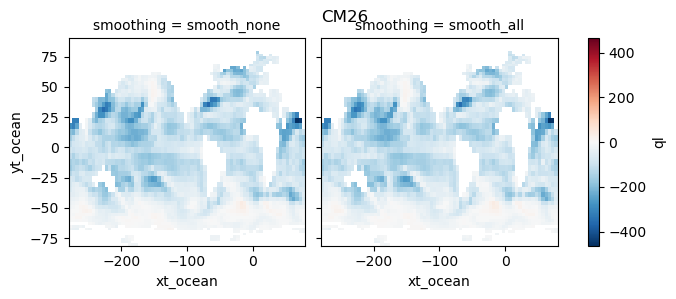

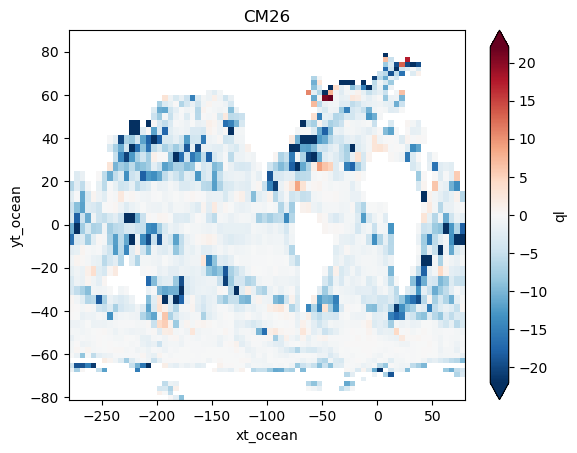

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 65.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 65.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

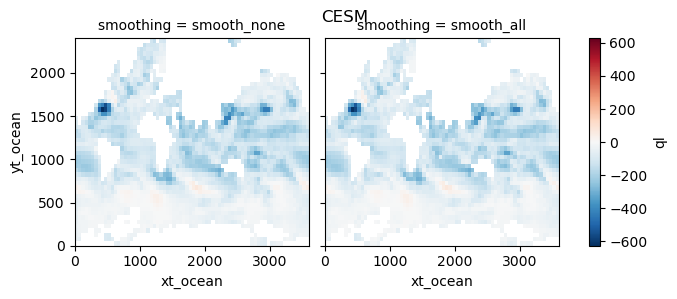

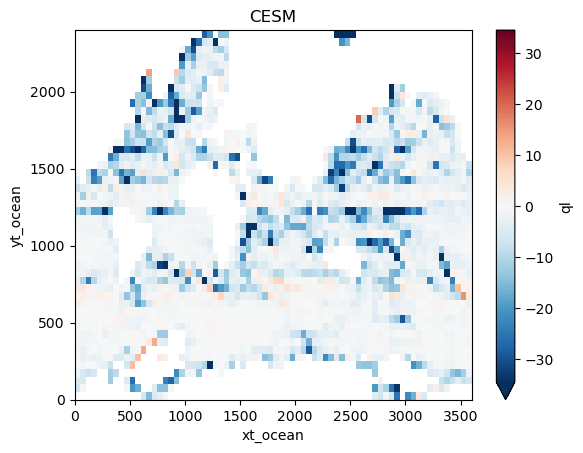

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 370.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 370.82 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

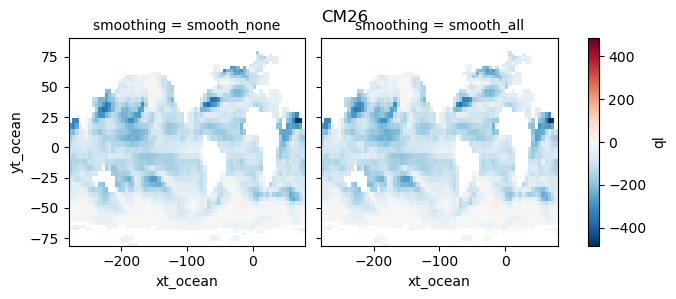

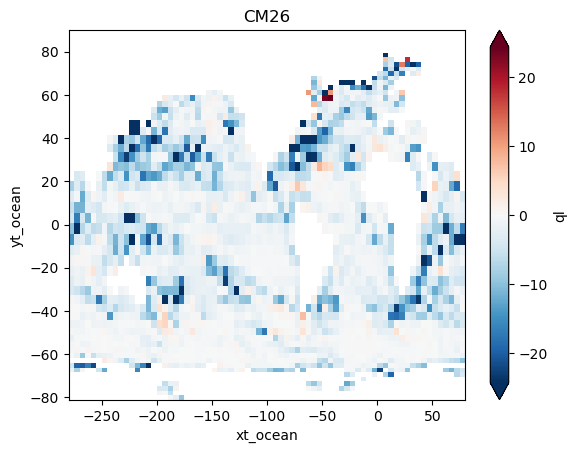

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 131.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 131.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

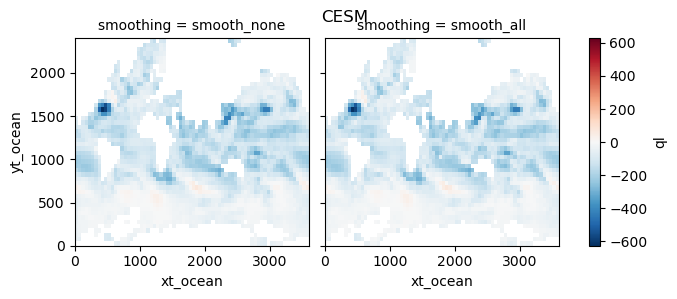

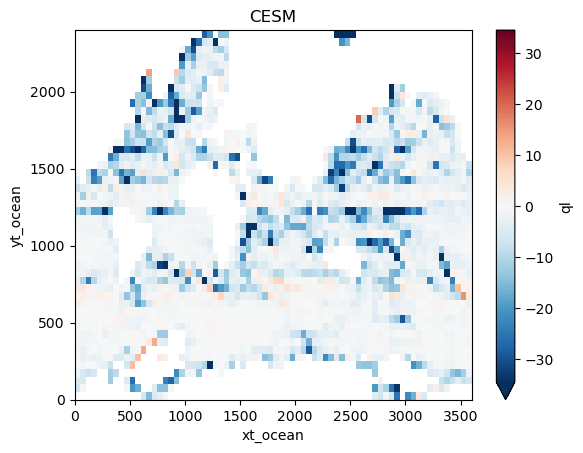

In [11]:
for model, ds in ds_coarse_fluxes_prod_dict.items():
    plt.figure()
    ds.ql.isel(time=0, algo=0).plot(col='smoothing')
    plt.suptitle(model)
    plt.figure()
    (-ds.ql.isel(time=0, algo=0).diff('smoothing')).plot(robust=True)
    plt.title(model)
    plt.show()
    
for model, ds in ds_coarse_fluxes_appendix_dict.items():
    plt.figure()
    ds.ql.isel(time=0, algo=0).plot(col='smoothing')
    plt.suptitle(model)
    plt.figure()
    (-ds.ql.isel(time=0, algo=0).diff('smoothing')).plot(robust=True)
    plt.title(model)
    plt.show()

## Pre-write tests


In [12]:
ds = ds_coarse_fluxes_prod_dict['CM26']

# test that both nan masks are the same
ds_test = ds.isel(time=0).load()
a = np.isnan(ds_test.isel(smoothing=0).drop('smoothing'))
b = np.isnan(ds_test).all('smoothing')
xr.testing.assert_allclose(a,b)

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 74.18 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


### Save coarsened data

I was thinking about rechunking the coarse source data, but that might actually cause problems with the one array that is coarsened from the filtered fields. Rechunking here at the end is fine for the resulting data and the overhead is probably small, since the dataset is fairly small at this point.

In [14]:
# the coarsening makes the data so small we need to make the time chunks bigger!
for model, ds_save in ds_coarse_fluxes_prod_dict.items():
    ds_save.chunk({'time':370}).to_zarr(params['paths'][model]['coarse_fluxes_prod'])
        
for model, ds_save in ds_coarse_fluxes_appendix_dict.items():
    ds_save.chunk({'time':370}).to_zarr(params['paths'][model]['coarse_fluxes_appendix'])

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 80.26 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 67.76 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 382.43 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 136.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [15]:
# reload the coarsened flux data
ds_reloaded_coarse_fluxes_prod = {}
for model in models:
    ds_reloaded_coarse_fluxes_prod[model] = open_zarr(params['paths'][model]['coarse_fluxes_prod'], chunks={})
    
ds_reloaded_coarse_fluxes_appendix = {}
for model in models:
    ds_reloaded_coarse_fluxes_appendix[model] = open_zarr(params['paths'][model]['coarse_fluxes_appendix'], chunks={})

#### Check missing time values

CM26


<Figure size 640x480 with 0 Axes>

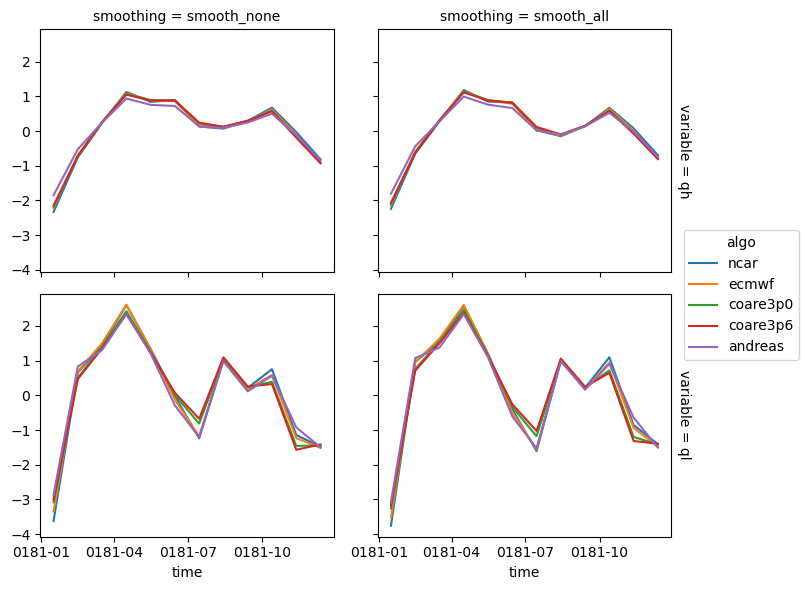

CESM


<Figure size 640x480 with 0 Axes>

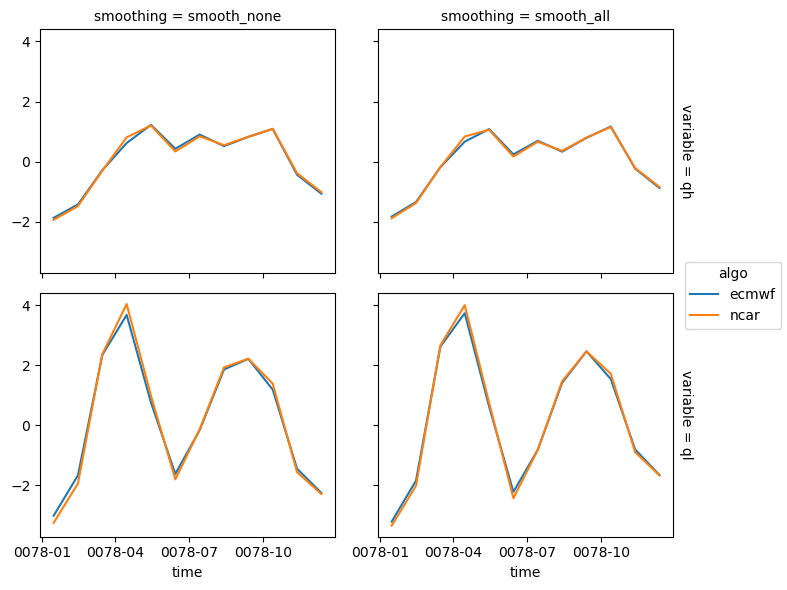

In [16]:
# for model, ds in ds_reloaded_coarse_fluxes_prod.items():
#     print(model)
#     plt.figure()
#     da_plot_coarse = ds.weighted(ds.area_t).mean(['xt_ocean', 'yt_ocean']).to_array().load()
#     (da_plot_coarse-da_plot_coarse.mean('time')).coarsen(time=30, boundary='trim').mean().plot(hue='algo', col='smoothing', row='variable')
#     plt.show()
    
for model, ds in ds_reloaded_coarse_fluxes_appendix.items():
    print(model)
    plt.figure()
    da_plot_coarse = ds.weighted(ds.area_t).mean(['xt_ocean', 'yt_ocean']).to_array().load()
    (da_plot_coarse-da_plot_coarse.mean('time')).coarsen(time=30, boundary='trim').mean().plot(hue='algo', col='smoothing', row='variable')
    plt.show()

In [27]:
cluster.shutdown()